In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords

## Loading Dataset into Pandas DataFrame

In [2]:
dataset=pd.read_csv("yelp_reviews.csv")

In [3]:
dataset.head(2)

,address,alias,avg_rating,city,country,physician,rating,state,text,time_created,title,url,user,zip_code
0,"35 E 21st St, Fl 7, New York, NY 10010",internalmed,4.5,New York,US,"Laura Guderian, MD",5,NY,I've been delighted with Dr. Guderian as my pr...,2017-09-06 13:21:59,Internal Medicine,https://www.yelp.com/biz/laura-guderian-md-new...,Bonnie E.,10010
1,"35 E 21st St, Fl 7, New York, NY 10010",internalmed,4.5,New York,US,"Laura Guderian, MD",1,NY,I really wanted to like One Medical Group. I a...,2016-09-25 16:00:50,Internal Medicine,https://www.yelp.com/biz/laura-guderian-md-new...,Yelpish N.,10010


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 14 columns):
address         145 non-null object
alias           145 non-null object
avg_rating      145 non-null float64
city            145 non-null object
country         145 non-null object
physician       145 non-null object
rating          145 non-null int64
state           145 non-null object
text            145 non-null object
time_created    145 non-null object
title           145 non-null object
url             145 non-null object
user            145 non-null object
zip_code        145 non-null int64
dtypes: float64(1), int64(2), object(11)
memory usage: 15.9+ KB


In [7]:
dataset.describe()

,avg_rating,rating,zip_code
count,145.000000,145.000000,145.000000
mean,4.375862,4.062069,10393.296552
std,0.708409,1.560007,757.288558
min,2.000000,1.000000,7030.000000
25%,4.000000,3.000000,10016.000000
50%,4.500000,5.000000,10028.000000
75%,5.000000,5.000000,11201.000000
max,5.000000,5.000000,11416.000000


### Text Length to represent How skewed the data is!
Reviews with maximum rating have longer length in comparison to reviews with less ratings

In [8]:
#To get an insight on the length of each review, we can create a new column in yelp called text length
dataset['text length'] = dataset['text'].apply(len)

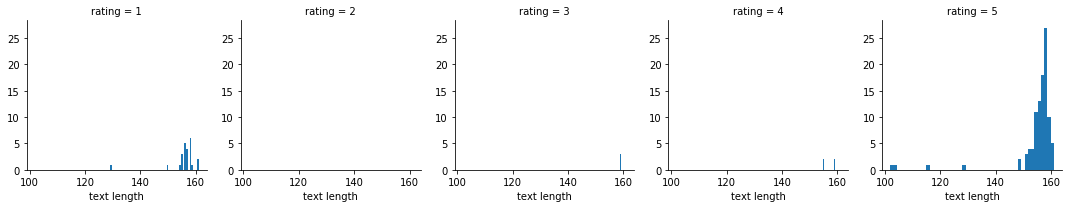

In [10]:
#Exploring the dataset
g = sns.FacetGrid(data=dataset, col='rating')
g.map(plt.hist, 'text length', bins=50)
#We can see thet there are high number of 5-star reviews

## Outlier Detection

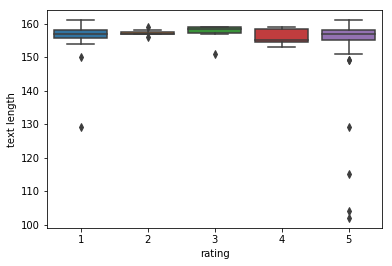

In [11]:
#As we can say that rating 1 ,2,3,4,5 are skewed towards right now we will se about outliers using box plots
sns.boxplot(x='rating', y='text length', data=dataset)
#as we can say there are outliers so text length as may not be as a best feature for predicting

In [12]:
#Finding the correlation
stars = dataset.groupby('rating').mean()
stars.corr()

,avg_rating,zip_code,text length
avg_rating,1.000000,0.467536,-0.459738
zip_code,0.467536,1.000000,-0.356836
text length,-0.459738,-0.356836,1.000000


### Correlation between Average Rating, ZIP Code and Length of Reviews

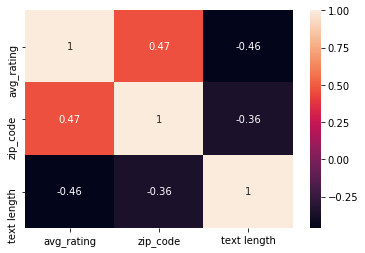

In [13]:
sns.heatmap(data=stars.corr(), annot=True)

### Creating Classes as Positive for 5 rating and Negative for 1 rating

In [14]:
#Our task is to predict either the review is good or bad so just grab reviews that are either 1 or 5 
yelp_class = dataset[(dataset['rating'] == 1) | (dataset['rating'] == 5)]

In [15]:
yelp_class.shape

(125, 15)

In [16]:
# as we can see there are 125 rows, this is because 
# we are not taking 2,3,4 rating into account becuase much data for these ratings are not available
#Let create x and y column for classification on the basis of text
X = yelp_class['text']
y = yelp_class['rating']

In [17]:
#Text Preprocessing
import string

def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [18]:
#Testing on a sample text
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."

print(text_process(sample_text))

['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


### Creating Bag of Words Transformer using Count Vectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer=text_process)
bow_transformer = count_vect.fit(X) # Bag of Words Transformer

In [20]:
len(bow_transformer.vocabulary_)

887

### A sample Review

In [21]:
review_2 = X[1]

In [22]:
review_2

"I really wanted to like One Medical Group. I am a terrible patient (I don't like being poisoned or abused.) and have had major problems in the past with..."

In [23]:
bow_2 = bow_transformer.transform([review_2])
bow_2

<1x887 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [24]:
X = bow_transformer.transform(X)

### Splitting Training and Testing Dataset

In [25]:
#Training and testing dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Fitting Data into Multinomila Naive Bayes Model for Sentiment Analysis

In [26]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
preds = nb.predict(X_test)

### Classification Report of Sentiment Analysis

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 2  7]
 [ 6 23]]


             precision    recall  f1-score   support

          1       0.25      0.22      0.24         9
          5       0.77      0.79      0.78        29

avg / total       0.64      0.66      0.65        38



### A positive Review Sample

In [29]:
positive_review = yelp_class['text'][0]

In [30]:
positive_review

"I've been delighted with Dr. Guderian as my primary care doctor. She is thoughtful, attentive, and kind. She responds to my questions and concerns promptly,..."

### Predicting Rating for the Positive Sample Review

In [31]:
positive_review_transformed = bow_transformer.transform([positive_review])

nb.predict(positive_review_transformed)[0]

5